In [41]:
from IPython.core.display import HTML

HTML('''
<style>

.banner {
    border-radius: 2px;
    border-left: solid 5px gray;
    padding-left: 1em;
}

.tip {
    background: lightgreen;
    border-left: solid 5px green;
}
.attention {
    background: yellow;
    border-left: solid 5px orange;
}

.warning {
    background: orange;
    border-left: solid 5px red;
}

.navigation {
    font-size: 1.05em;
    color: gray;
}

.navigation:hover {
    color: black;
}

.content {
    font-size: 1.1em;
}
</style>''')

# Presentation on Word2Vec
Glenn Abastillas | 24 March, 2020

``` ADD VISUAL OF KING - QUEEN = MAN WITH SVG ```

This notebook goes over an example implementation of Word2Vec and some existing packages that perform Word2Vec training.

Contents
  1.  Preliminary Steps
      * [Load Packages](#load_packages)
      * [Preprocess Data](#preprocess_data)
      * [Quick Background](#quick_background)
  2. [Implementation from Scratch](#implementation_from_scratch)
      * Word2Vec Flavors: Continuous Back of Words (CBOW) / Skip Grams (SG)
      * Training
      * Retrieving the trained matrix
      * Applications
  3. Using an Existing Package

__At each step, we will also cover other packages that can be used to acheive the same thing (e.g., Countvectorizer)__
  
<p class='tip banner'>This is an example of a tip.<p>
<p class='attention banner'>This is an example of an attention.<p>
<p class='warning banner'>This is an example of a warning.<p>
  
---

### Load Packages <a id="load_packages"></a>
First we import packages and clean the data.

In [1]:
import numpy as np
import spacy
import tqdm
from string import punctuation
from nltk.corpus import gutenberg, stopwords
from collections import namedtuple

We will use data from the `gutenberg` corpus and normalize the input data.

In [2]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [3]:
sents = gutenberg.sents('blake-poems.txt')
print(f'Number of sentences: {len(sents)}')

Number of sentences: 438


`[insert navigation here]`

---
### Preprocess Data <a id="preprocess_data"></a>
##### Normalize Vocabulary

To improve processing and richness of our lexical items, we normalize our language data. 

Normalizing data can involve a variety of tasks depending on the final application of our language model. These tasks including making all words the same case, removing punctuation, and removing **<a id="stopword" style="text-decoration: none; cursor: help;" title="Words that contribute little semantic information to a text">stopwords</a>**.

For this presentation, we will use **<a id="token" style="text-decoration: none; cursor: help;" title="Combinations of characters separated by spaces (e.g., words, numbers)">tokens</a>** that are not punctuation nor stopwords.

Let's quickly define some functions we will use to pare our text data down.

In [4]:
stopwords_ = stopwords.words('english')

def is_stopword(token):
    ''' Check if a specified token is a stopword. '''
    try:
        return token.lower() in stopwords_
    except:
        return False

def is_valid_token(token):
    ''' Check if token is valid, i.e., not a stopword or punctuation '''
    try:
        return token.isalnum() & ~is_stopword(token)
    except:
        return False

##### First Normalization Step
Next, we create our `raw_text` data using the functions we just defined.

In [5]:
%%time
normalized_sents = [[word.lower() for word in sent if is_valid_token(word)] for sent in sents]

print(f'Number of sentences : {len(normalized_sents)}')

Number of sentences : 438
CPU times: user 78.9 ms, sys: 6.55 ms, total: 85.5 ms
Wall time: 89.6 ms


With our `normalized_text`, we can create a `dict` to convert the strings into numbers for faster processing down the line. We also create maps for strings to integers, integers to strings, and a probability distribution of word frequencies for possible negative sampling (if there is time).

In [6]:
flattened_text = [word for sent in normalized_sents for word in sent]

WORDS, COUNTS = np.unique(flattened_text, return_counts=True)

PROBS = COUNTS**(3/4) / (COUNTS**(3/4)).sum()

INDEX = np.arange(WORDS.size)

VOCAB = dict(zip(WORDS, INDEX))
VOCABR = dict(zip(INDEX, WORDS))

print(f'Vocabulary size: {WORDS.size}')

Vocabulary size: 1402


##### Second Normalization Step

Using the conversion function defined above, we can convert our `normalized_sents` into `data`, which contains only integers that will be used in our Word2Vec example.

In [7]:
%%time
data = (np.array([VOCAB[token] for token in sent]) for sent in normalized_sents)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


`[insert navigation here]`

---

Use this reference for later [Dimensions greater than 300 have diminishing returns](https://www.aclweb.org/anthology/D14-1162/)

### Quick Background <a id="quick_background"></a>
#### Background Into Word2Vec

* What is it?
  - <p class='content'>Quick definition (implementation of theoretical matrix bit): A method or representing words as numerical vectors, which allow us to improve the efficiency of our models as well as enable us to glean insight on how words behave in a text.</p>
  - What is does to text: The Word2Vec model converts words as strings into an array of numbers of n-dimensions by training a shallow neural network and keeping only the trained weights.
  - What the output is: The trained weights from the neural network we train are conveniently also act as the word vectors themselves in a matrix format.
  
* Why do we need it?
  - Many uses in AI: Semantic analysis, entity discovery, lexical and lexical relationship analysis, and topic modeling.
  - Pros: We can do algebra with words and converting strings to numeric vectors unlocks a host of abilities that we can perform on these numeric vectors.
  - Cons: We need a large vocabulary and training can be very time and resources heavy.
 
* What cool things can it do?
  - Condense text into a lightweight matrix
  - Provide semantic abilities
  - Enable data to have algebraic properties
 
* What are competing models?
  - Other models to represent text
  - GloVe
  - Other vectorization models

`[insert navigation here]`

---
## Implementation from Scratch <a id="implementation_from_scratch"></a>

For things example, we will create a Word2Vec language model using the data we preprocessed above. 

In this section, we will develop a **<a id="skip-gram" style="text-decoration: none; cursor: help;" title="Using the a token to predict its surroundings">Skip-gram</a>** flavored Word2Vec model.

We will:
  * Create Skip-gram windows
  * Create preliminary <a id='one-hot' style='text-decoration: none; cursor: help;' title='A vector that is comprised of zeros and ones indicating absence or presence of a value'>one-hot vectors</a>


###### Parameters <a id='parameters'></a>
First we define some hyperparameters that we use for training.

In [8]:
parameters = {'window_size' : 2, 'dimensions' : 100, 'learning_rate' : 0.02, 'epochs' : 3}

<style>
table, td, tr {
    border: solid 1px gray;
    background: green;
}
</style>
This table quickly describes what each parameter does.

Parameters | Data Type | Description
--- | :-: | :--
`window_size` | `int` | The number of target tokens before and after a central token to include
`dimensions` | `int` | The number of dimensions in hidden layer. Dimensions greater than 300 have diminishing returns `[cite]`.
`learning_rate` | `float` | How quickly our model will correct itself
`epochs` | `int` | The number of rounds the model is trained

##### Creating the Training Data <a id="creating_the_training_data"></a>

We will generate loose <a id='one-hot' style='text-decoration: none; cursor: help;' title='A vector that is comprised of zeros and ones indicating absence or presence of a value'>one-hot vectors</a> that will serve as input and target data when training our model.

First we filter our data to ensure we have sufficient data to window.

In [9]:
%%time
data = [sent for sent in data if sent.size >= parameters['window_size'] + 1]

print(f'Number of sentences in data: {len(data)}')

Number of sentences in data: 358
CPU times: user 4.03 ms, sys: 832 µs, total: 4.86 ms
Wall time: 4.57 ms


Now, we generate our one hot vectors using the `VOCAB` as a model for our vector.

Let's define a few functions to help use generate these data.

In [10]:
Datum = namedtuple('Datum', 'target context'.split())

def one_hot(token, size=WORDS.size):
    ''' Convert an input token into an integer according to a specified reference '''
    vector = np.zeros((size, 1))
    vector[token] = 1
    return vector

def process_sentence(sent, processed_sentence={}, window_size=parameters['window_size'] + 1):
    ''' Return a dictionary with token keys and contexts as values
        
        Parameters
        ----------
            sent (list) : sentence to convert into one-hot vectors 
                          and group into target and context
            processed_sentence (dict) : Previously processed sentences to add to
            window_size (int) : Window size of CBOW
        
        Returns
        -------
            (dict) object with tokens as keys and their corresponding
                   one-hot vector targets and context in the following format:
            
            >> { token : [[target, [context-1, context-2, ...]], ...]}
    '''
    for i, token in enumerate(sent):
        a, b, j = max(i - window_size, 0), i + window_size, i+1
        before, after = sent[a:i], sent[j:b]

        context = []

        # Loop through the surrounding tokens
        for context_token in np.append(before, after):
            try:
                context.append(one_hot(context_token))
            except:
                print(token, context_token, a, b, before, after, sent[a:b])
                raise
        
        if token in processed_sentence:
            processed_sentence[token].context.append(context)
        else:
            target = one_hot(token)
            processed_sentence[token] = Datum(target, [context])

    return processed_sentence

Loop through all the sentences to generate `target` and `context` data for training.

In [11]:
processed_sentences = {}
for sent in tqdm.tqdm(data):
    processed_sentences = process_sentence(sent, processed_sentences)


100%|██████████| 358/358 [00:00<00:00, 1223.76it/s]


<p class='attention'>&uparrow; Processing time may vary </p>

`[insert navigation here]`

---
##### Create Layers <a id='create_layers'></a>

These matrices will serve as the layers that surround our `word2vec` layer during training.

In [12]:
weights_1 = np.random.random((WORDS.size, parameters['dimensions']))
weights_2 = np.random.random((WORDS.size, parameters['dimensions']))
print(f'Dimensions\nWeights 1 {weights_1.shape}\nWeights 2 {weights_2.shape}')

Dimensions
Weights 1 (1402, 100)
Weights 2 (1402, 100)


`[insert navigation here]`

---
###### Feed Forward Algorithm

The first part of a two part algorithm defining a <a id='learning-step' style='text-decoration: none; cursor: help;' title='A phase where training data are learned and errors are adjusted throughout the model'>learning step</a>. This algorithm introduces our randomly initialized model to its first evidence of real data to learn from. It then predicts a surrounding vocabulary item from it.

In [13]:
def softmax(datum):
    ''' Return the an array normalized to a probability '''
    e = np.exp(datum - datum.max())
    return e / e.sum()

def forward(datum, weights_1=weights_1, weights_2=weights_2):
    ''' Return three matrices corresponding to the prediction, hidden layer, and output '''
    hidden = np.dot(weights_1.T, datum)
    output = np.dot(weights_2, hidden)
    prediction = softmax(output)
    return prediction, hidden, output

`[insert navigation here]`

---
###### Backpropagation Algorithm

The second part of the two part algorithm defining a <a id='learning-step' style='text-decoration: none; cursor: help;' title='A phase where training data are learned and errors are adjusted throughout the model'>learning step</a>. This algorithm compares the output of the <a id='feed-forward-algorithm' style='text-decoration: none; cursor: help;' title='The algorithm that takes in new data and attempts to make predictions from it'>feed forward algorithm</a> to the input token's actual context, calculates the error, and adjusts the model to correct for it. The adjustments are made in increments set by the learning rate parameter we set in our `parameters` variable.

In [14]:
def calculate_error(prediction, context):
    ''' Return a weights with the summed prediction error '''
    error = np.zeros((prediction.size, 1))
    for subcontext in context:
        for token in subcontext:
            error += prediction - token
    return error

def backpropagate(prediction, hidden, target, context, weights_1=weights_1, weights_2=weights_2, index=INDEX):
    ''' Update weight matrices according to output from forward() '''
    error = calculate_error(prediction, context)

    sample = negative_sample(context)
    target_index = index[target.flatten() == 1]
    sample = np.append(target_index, sample)
    error[~sample] = 0
    
    weights_2_delta = np.outer(error, hidden)
    hidden_error = np.dot(weights_2.T, error)
    weights_1_delta = np.outer(hidden_error, target).T
    
    weights_1 -= weights_1_delta * parameters['learning_rate']
    weights_2 -= weights_2_delta * parameters['learning_rate']
    
def negative_sample(context, n=5, index=INDEX, probs=PROBS):
    ''' Return an array of randomly sampled tokens to be updated '''
    positives = sum([sum(c) for c in context]).flatten() >= 1
    negatives = np.invert(positives)
    sample = index[negatives]
    p = probs[negatives] / probs[negatives].sum()
    return np.random.choice(sample, n, p=p)

Sandbox to do negative_sample

In [ ]:
example = processed_sentences[1]
target, context = example.target, example.context

In [ ]:
pred, h, u = forward(target)

In [ ]:
%%time
backpropagate(pred, h, target, context)

`[insert navigation here]`

---
##### Training Algorithm

Having both the feed forward and backpropagation algorithms defined, we can now define a training algorithm to learn all training examples for a single <a id='epoch' style='text-decoration: none; cursor: help;' title='A complete cycle of learning steps through all training data'>epoch</a>.

In [43]:
def train(training_data, weights_1=weights_1, weights_2=weights_2, parameters=parameters, total=WORDS.size):
    ''' Train the Word2Vec model on our training data to generate meaningful word vectors '''
    
    data = tqdm.tqdm(training_data.items())

    for epoch in tqdm.trange(50):
        for __, (target, context) in data:
#         for __, (target, context) in tqdm.trange(data, total = len(data)):
            prediction, hidden, output = forward(target)
            backpropagate(prediction, hidden, target, context)

`[insert navigation here]`

---
###### Test Iteration <a id='test_iteration'></a>

This cell loops through all our training data to demonstrate what happens in one training <a id='epoch' style='text-decoration: none; cursor: help;' title='A complete cycle of learning steps through all training data'>epoch</a>.

<p class='warning'>Processing time may vary</p>

In [44]:
%%time
train(processed_sentences)

100%|██████████| 50/50 [03:21<00:00,  4.04s/it]

CPU times: user 3min 3s, sys: 16.7 s, total: 3min 20s
Wall time: 3min 21s


##### Looking at Some Examples

We define some functions to inspect the output of our model.

In [17]:
def word_vector(token, model=weights_1):
    ''' Return the word vector corresponding to a token '''
    return model[token]

def similarity(vector1, vector2):
    ''' Return the cosine similarity score for two tokens input as vectors '''
    if isinstance(vector1, int):
        vector1 = word_vector(vector1)
        
    if isinstance(vector2, int):
        vector2 = word_vector(vector2)
        
    a = np.dot(vector1, vector2)
    b = np.dot(vector1, vector1)
    c = np.dot(vector2, vector2)
    return a / (np.sqrt(b) * np.sqrt(c))

We inspect randomly selected words for their similarity score where $similarity \in [-1,1]$

In [64]:
v1 = np.random.randint(0, WORDS.size)
v2 = np.random.randint(0, WORDS.size)
print(f'{VOCABR[v1]} and {VOCABR[v2]}')
similarity(v1, v2)

increase and sick


-0.9999999999999999

Test the current model trained only on a single epoch.

In [54]:
token = np.random.randint(0, WORDS.size)
a, b = weights_1[token - 1], weights_1[token]
distance = np.dot(a,b) / (np.sqrt(np.dot(a, a)) * np.sqrt(np.dot(b,b)))

print(f'Token number {token} is "{VOCABR[token]}" along with "{VOCABR[token-1]}" with cos score as {distance}')

Token number 1194 is "terror" along with "terrific" with cos score as 0.9999999999999998


In [45]:
np.savetxt('20200326_blake-poems.csv', weights_1, delimiter=',')

`[insert navigation here]`

---
#### Using Our Trained Model

We can use our trained model to `list things we can do with our Word2Vec model from earlier`.

First, we define functions to help do those things.

In [ ]:
def most_similar(token, model=weights_1):
    ''' Return the token and vector of the most similar token in the model to input token '''
    best_score = -1
    token_vector = word_vector(token)
    best_vector = None
    for i, current_vector in enumerate(model):
        if i == token:
            continue
            
        score = similarity(token_vector, current_vector)
        if score > best_score:
            best_score = score
            best_vector = i
    return best_vector, best_score


def topn(token, n=3, model=weights_1):
    ''' Return the top n tokens and vectors most closely related to input token '''
    
    similarity_scores, vectors = [], []
    token_vector = word_vector(token, model)
    
    for i, current_vector in enumerate(model):
        score = similarity(token_vector, current_vector)
        
        if similarity_scores and similarity_scores[0] < score:
            similarity_scores.insert(0, score)
            vectors.insert(0, i)
        

Test with algebraic interactions of this 

In [ ]:
most_similar(994)

In [ ]:
VOCABR[994], VOCABR[8066]

In [ ]:
similarity(word_vector(343), word_vector(344)), VOCABR[343], VOCABR[344]

### Visualize Word2Vec

In [20]:
import altair as alt
import matplotlib.pyplot as plt

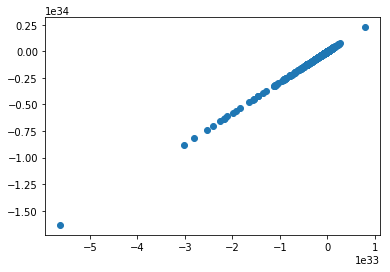

In [67]:
plt.scatter(weights_1[:,1], weights_1[:,62])

---

In [ ]:
vector.shape, matrix_1.shape

In [ ]:
pred, h, u = forward(vector, matrix_1, matrix_2)
pred.shape, h.shape, u.shape

In [ ]:
VOCABR[vector.argmax()]

In [ ]:
VOCABR[pred.argmax()]

## Using an Existing Package

There are existing implementations that already exist that allow you to use Word2Vec technology out of the box.

Examples of these include:
  * SpaCy
  * gensim
  * ELMo
  * fasttext
 
 
### SpaCy

In [ ]:
nlp = spacy.load('en_core_web_sm')